<a href="https://colab.research.google.com/github/giozu/FEniCS/blob/main/2D%20problems/2d_poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Equation and problem definition

For a domain $\Omega \subset \mathbb{R}^n$ with boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$, the Poisson equation with
particular boundary conditions reads:

$$
\begin{align}
- \nabla^{2} u &= f \quad {\rm in} \ \Omega, \\
u &= 0 \quad {\rm on} \ \Gamma_{D}, \\
\nabla u \cdot n &= g \quad {\rm on} \ \Gamma_{N}. \\
\end{align}
$$

where $f$ and $g$ are input data and $n$ denotes the outward directed
boundary normal. The variational problem reads: find $u \in V$ such
that

$$
a(u, v) = L(v) \quad \forall \ v \in V,
$$

where $V$ is a suitable function space and

$$
\begin{align}
a(u, v) &:= \int_{\Omega} \nabla u \cdot \nabla v \, {\rm d} x, \\
L(v)    &:= \int_{\Omega} f v \, {\rm d} x + \int_{\Gamma_{N}} g v \, {\rm d} s.
\end{align}
$$

The expression $a(u, v)$ is the bilinear form and $L(v)$
is the linear form. It is assumed that all functions in $V$
satisfy the Dirichlet boundary conditions ($u = 0 \ {\rm on} \
\Gamma_{D}$).

In this exercise, we consider:

- $\Omega = [0,2] \times [0,1]$ (a rectangle)
- $\Gamma_{D} = \partial \Omega\$
- $f = 1.0$


## Implementation

The modules that will be used are imported:

In [90]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot
from ufl import ds, dx, grad, inner

from mpi4py import MPI
from petsc4py.PETSc import ScalarType

## Initializing notebook plotting
When running a python notebook, a special line is necessary to show the plots.

In [91]:
%matplotlib inline

## Mesh generation and functional spaces
We create a rectangular {py:class}`Mesh <dolfinx.mesh.Mesh>` using
{py:func}`create_rectangle <dolfinx.mesh.create_rectangle>`, and
create a finite element {py:class}`FunctionSpace
<dolfinx.fem.FunctionSpace>` $V$ on the mesh.

The second argument to {py:class}`FunctionSpace
<dolfinx.fem.FunctionSpace>` is a tuple `(family, degree)`, where
`family` is the finite element family, and `degree` specifies the
polynomial degree. In this case `V` is a space of continuous Lagrange
finite elements of degree 1.

To apply the Dirichlet boundary conditions, we find the mesh facets
(entities of topological co-dimension 1) that lie on the boundary
$\Gamma_D$ using {py:func}`locate_entities_boundary
<dolfinx.mesh.locate_entities_boundary>`. The function is provided
with a 'marker' function that returns `True` for points `x` on the
boundary and `False` otherwise.

We now find the degrees-of-freedom that are associated with the
boundary facets using {py:func}`locate_dofs_topological
<dolfinx.fem.locate_dofs_topological>`:

and use {py:func}`dirichletbc <dolfinx.fem.dirichletbc>` to create a
{py:class}`DirichletBCMetaClass <dolfinx.fem.DirichletBCMetaClass>`
class that represents the boundary condition:

In [92]:
# msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
#                             points=((0.0, 0.0), (2.0, 1.0)), n=(32, 16),
#                             cell_type=mesh.CellType.triangle,)

msh = mesh.create_unit_square(MPI.COMM_WORLD, 12, 12, mesh.CellType.quadrilateral)

V = fem.FunctionSpace(msh, ("Lagrange", 1))

# Create facet to cell connectivity required to determine boundary facets
tdim = msh.topology.dim
fdim = tdim - 1
msh.topology.create_connectivity(fdim, tdim)

# facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
#                                        marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
#                                                                       np.isclose(x[0], 2.0)))

facets = mesh.exterior_facet_indices(msh.topology)
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)


## Variational problem solution
The variational problem is defined:

A {py:class}`LinearProblem <dolfinx.fem.LinearProblem>` object is
created that brings together the variational problem, the Dirichlet
boundary condition, and which specifies the linear solver. In this
case an LU solver us sued. The {py:func}`solve
<dolfinx.fem.LinearProblem.solve>` computes the solution.

In [93]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
# f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
f = 10.0
# g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx # + inner(g, v) * ds

problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# The solution can be written to a {py:class}`XDMFFile
# <dolfinx.io.XDMFFile>` file visualization with ParaView or VisIt:

with io.XDMFFile(msh.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

## Visualization
displayed using [pyvista](https://docs.pyvista.org/).


In [94]:
try:
    import pyvista
    cells, types, x = plot.create_vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()

except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")
# -


Widget(value="<iframe src='http://localhost:33765/index.html?ui=P_0x7ff51d4ccf10_12&reconnect=auto' style='wid…

## Curve plots throughout the mesh
It is possible to plot the solution along a line. Let's consider $x=0$. First, we define a set of point along the $y$-axis, then we evaluate the finite element solution $u$ at these points.

The finite element function is the linear combination of all degrees of freedom, $u_h = \Sum_{i=1}^N c_i \phi_i(x), where $c_i$ are the coefficients of $u_i$ and $\phi_i$ are the the basis function. We can compute the exact solution at any point in $\Omega$. However, as a mesh consists of a large set of degrees of freedom (i.e. $N$ is large), we want to reduce the number of evaluations of the basis functions $\phi_i(x)$. We do this by identifying which cell of the mesh is in. This is efficiently done by creating a bounding box tree of the cells of the mesh, allowing a quick recursive search through the mesh entities.

In [80]:
from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)

cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)

# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])





We now got a list of points on the processor, on in which cell each point belongs. We can then call uh.eval and pressure.eval to obtain the set of values for all the points.

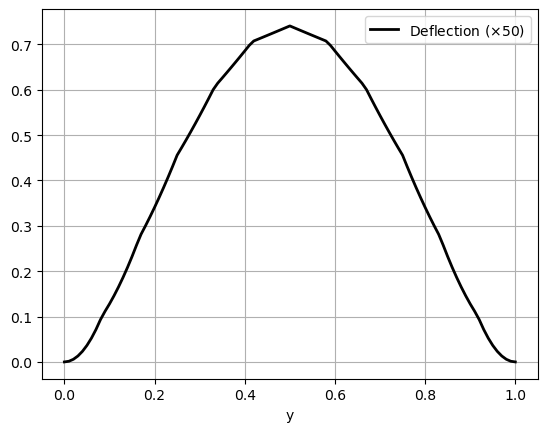

In [104]:
from dolfinx import geometry

points = np.zeros((3, 101))

points[0] = np.linspace(0, 1, 101)
points[1] = np.linspace(0, 1, 101)


u_values = []
cells = []
points_on_proc = []

bb_tree = geometry.BoundingBoxTree(msh, msh.topology.dim)

cell_candidates = geometry.compute_collisions(bb_tree, points.T)
colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, points.T)

for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
        
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_proc[:,1], u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.grid(True)
plt.xlabel("y")
plt.legend()